Looking at a dynamic programming solution for the case of ["next card bet"](https://github.com/WinVector/Examples/blob/main/puzzles/next_card_bet/Kelly_cant_fail.ipynb) with invisible stakes.

In [1]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
from plotnine import *
from card_count_fns import (
    basic_bet_strategy,
    bet_amt_min,
    dynprog_bet_strategy,
    k_array_with_t_true,
    mk_traj_frame,
    run_bets,
    run_bets_int,
    theoretical_payout,
    )

In [2]:
rng = np.random.default_rng(2024)

In [3]:
initial_stake = 100
n_cards_per_color = 26
limit_to_basic_strat = True  # not an exhaustive search if True, but if we match expected minimum it is valid


In [4]:
ideal_return = theoretical_payout(n_cards_per_color, n_cards_per_color)

ideal_return

9.08132954942779

In [5]:
satiation_point = int(np.ceil(ideal_return * initial_stake))

In [6]:
# get unconstrained best possible min bound
_, min_payoff_bound_u = bet_amt_min(
    initial_stake, n_cards_per_color, n_cards_per_color, satiation_point,
    limit_to_basic_strat=False,
)

min_empirical_return_rate_bound = min_payoff_bound_u / initial_stake


min_empirical_return_rate_bound

8.08

In [7]:
decks = [
    k_array_with_t_true(2 * n_cards_per_color, n_cards_per_color, rng=rng)
    for _ in range(10000)
]

In [8]:
payoffs_basic = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=0,
        bet_strategy=basic_bet_strategy,
        limit_to_basic_strat=limit_to_basic_strat,
    )[0]
    for deck in decks
]

(np.min(payoffs_basic), np.mean(payoffs_basic), np.max(payoffs_basic))

(0.02, 9.082086000000002, 40.96)

In [9]:
assert np.min(payoffs_basic) > 0

In [10]:
np.std(payoffs_basic)

0.46441068958842874

In [11]:
plt_frame_basic = pd.DataFrame({"return": payoffs_basic, "strategy": "basic"})

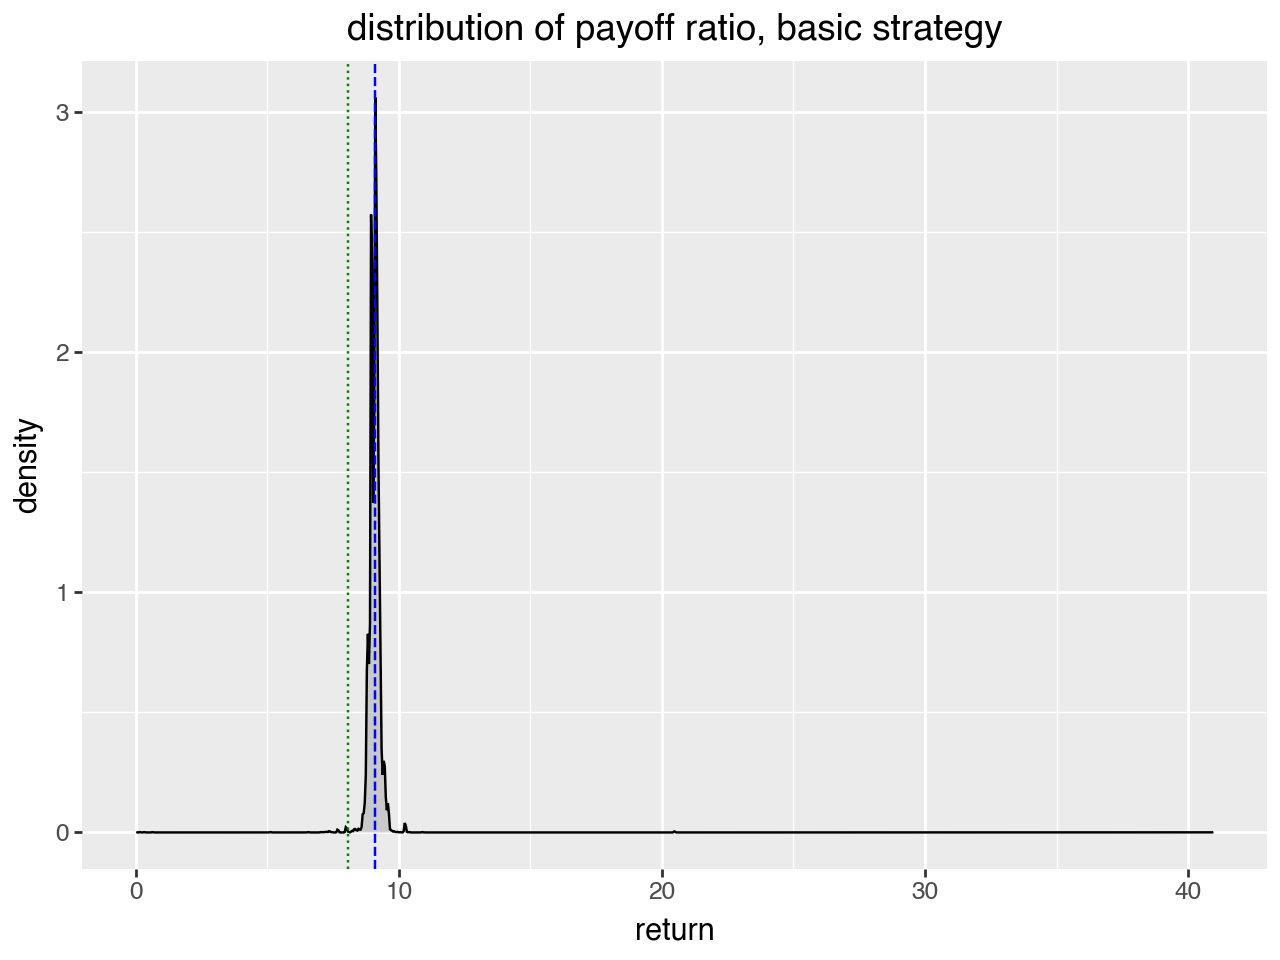

In [12]:
(
    ggplot(data=plt_frame_basic, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=min_empirical_return_rate_bound, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, basic strategy")
)

In [13]:


_, min_payoff_constrained = bet_amt_min(
    initial_stake, n_cards_per_color, n_cards_per_color, satiation_point,
    limit_to_basic_strat=limit_to_basic_strat,
)

min_empirical_return_rate = min_payoff_constrained / initial_stake

assert min_empirical_return_rate == min_empirical_return_rate_bound

min_empirical_return_rate

8.08

In [14]:
payoffs_dynprog = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=dynprog_bet_strategy,
        limit_to_basic_strat=limit_to_basic_strat,
    )[0]
    for deck in decks
]
assert np.min(payoffs_dynprog) >= min_empirical_return_rate

(np.min(payoffs_dynprog), np.mean(payoffs_dynprog), np.max(payoffs_dynprog))

(8.26, 9.073688, 40.96)

In [15]:
assert np.min(payoffs_dynprog) > 0

In [16]:
np.std(payoffs_dynprog)

0.6855467297391185

In [17]:
plt_frame_dynprog = pd.DataFrame({"return": payoffs_dynprog, "strategy": "dynprog"})

np.std(plt_frame_dynprog["return"])

0.6855467297391307

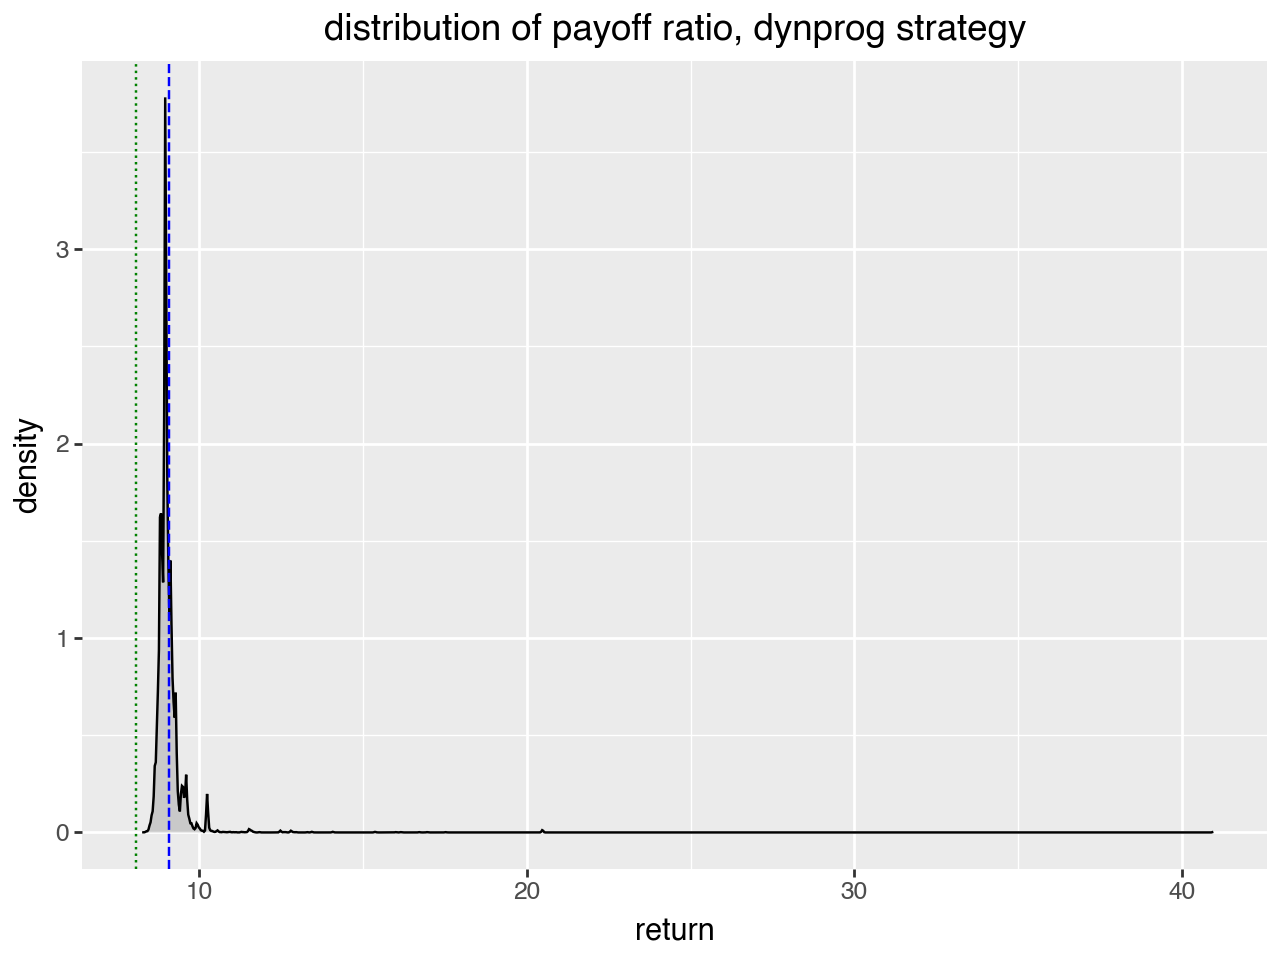

In [18]:
(
    ggplot(data=plt_frame_dynprog, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, dynprog strategy")
)

In [19]:
plt_frame_both = pd.concat(
    [
        plt_frame_basic,
        plt_frame_dynprog,
    ],
    ignore_index=True,
)
plt_lower_bound = np.quantile(plt_frame_both["return"], 0.001)
plt_upper_bound = np.quantile(plt_frame_both["return"], 0.995)

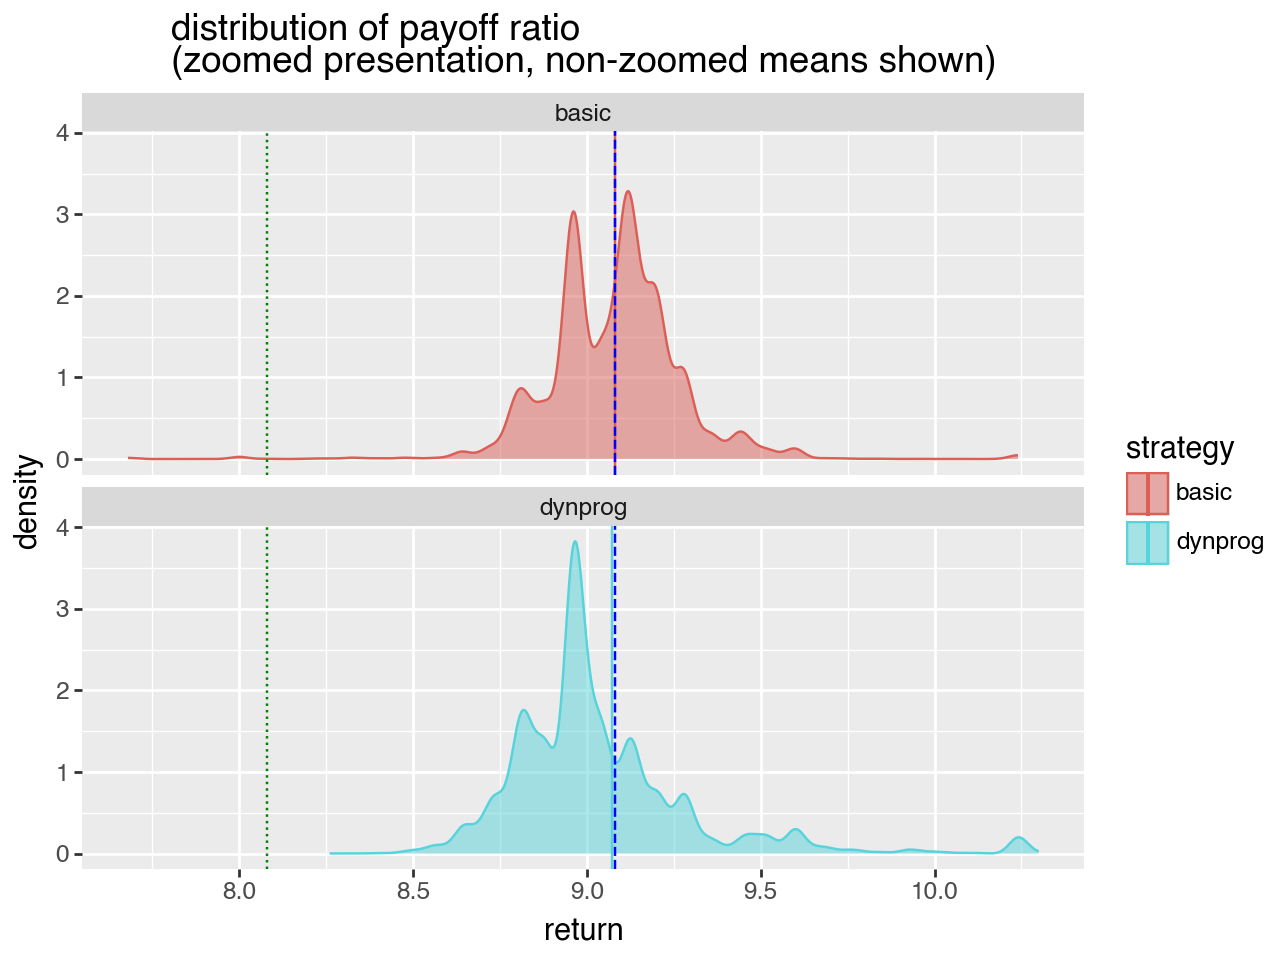

In [20]:
means_both = (
    plt_frame_both.groupby(["strategy"]).mean().reset_index(drop=False, inplace=False)
)
(
    ggplot(
        data=plt_frame_both.loc[
            (plt_frame_both["return"] >= plt_lower_bound)
            & (plt_frame_both["return"] <= plt_upper_bound),
            :,
        ],
        mapping=aes(x="return", color="strategy", fill="strategy"),
    )
    + geom_density(alpha=0.5, trim=True)
    + geom_vline(data=means_both, mapping=aes(xintercept="return", color="strategy"))
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + facet_wrap("strategy", ncol=1)
    + ggtitle(
        "distribution of payoff ratio\n(zoomed presentation, non-zoomed means shown)"
    )
)

In [21]:
# overall stats
(plt_frame_both.groupby(["strategy"]).agg(["mean", "std"]))

return          
              mean       std
strategy                    
basic     9.082086  0.464434
dynprog   9.073688  0.685581

In [22]:
# zoomed stats
(
    plt_frame_both.loc[
        (plt_frame_both["return"] >= plt_lower_bound)
        & (plt_frame_both["return"] <= plt_upper_bound),
        :,
    ]
    .groupby(["strategy"])
    .agg(["mean", "std"])
)

return          
              mean       std
strategy                    
basic     9.081012  0.195083
dynprog   9.034053  0.266917

In [23]:
compare_frame = pd.DataFrame(
    {
        "basic": payoffs_basic,
        "dynprog": payoffs_dynprog,
    }
)

In [24]:
np.min(compare_frame["basic"])

0.02

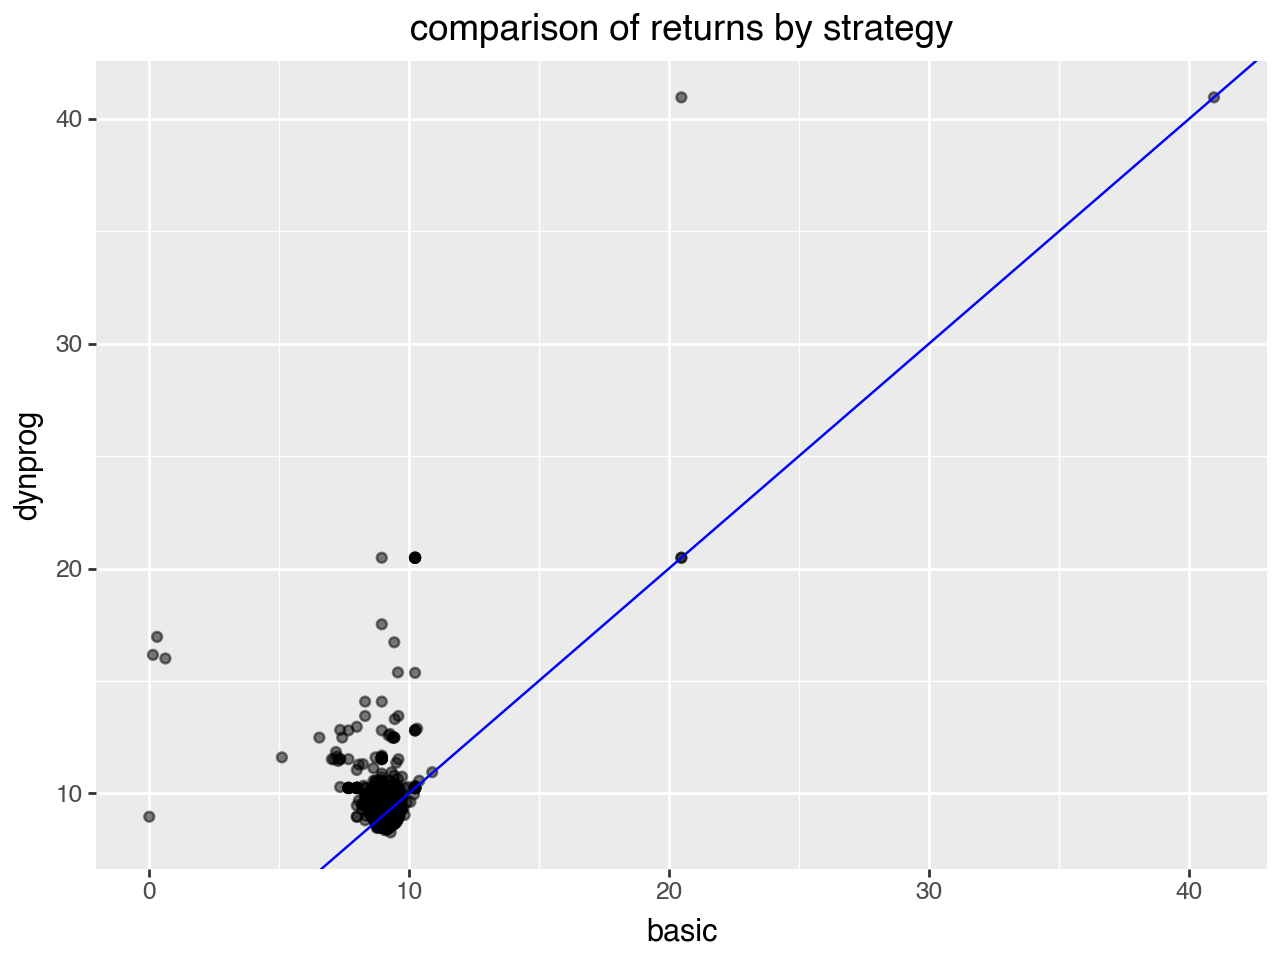

In [25]:
(
    ggplot(data=compare_frame, mapping=aes(x="basic", y="dynprog"))
    + geom_point(alpha=0.5)
    + geom_abline(intercept=0, slope=1, color="blue")
    + ggtitle("comparison of returns by strategy")
)

In [26]:
trajectories = [
    mk_traj_frame(
        i,
        bet_strategy=basic_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
        limit_to_basic_strat=limit_to_basic_strat,
    )
    for i in range(1000)
] + [
    mk_traj_frame(
        i,
        bet_strategy=dynprog_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
        limit_to_basic_strat=limit_to_basic_strat,
    )
    for i in range(1000)
]
trajectories = pd.concat(trajectories, ignore_index=True)

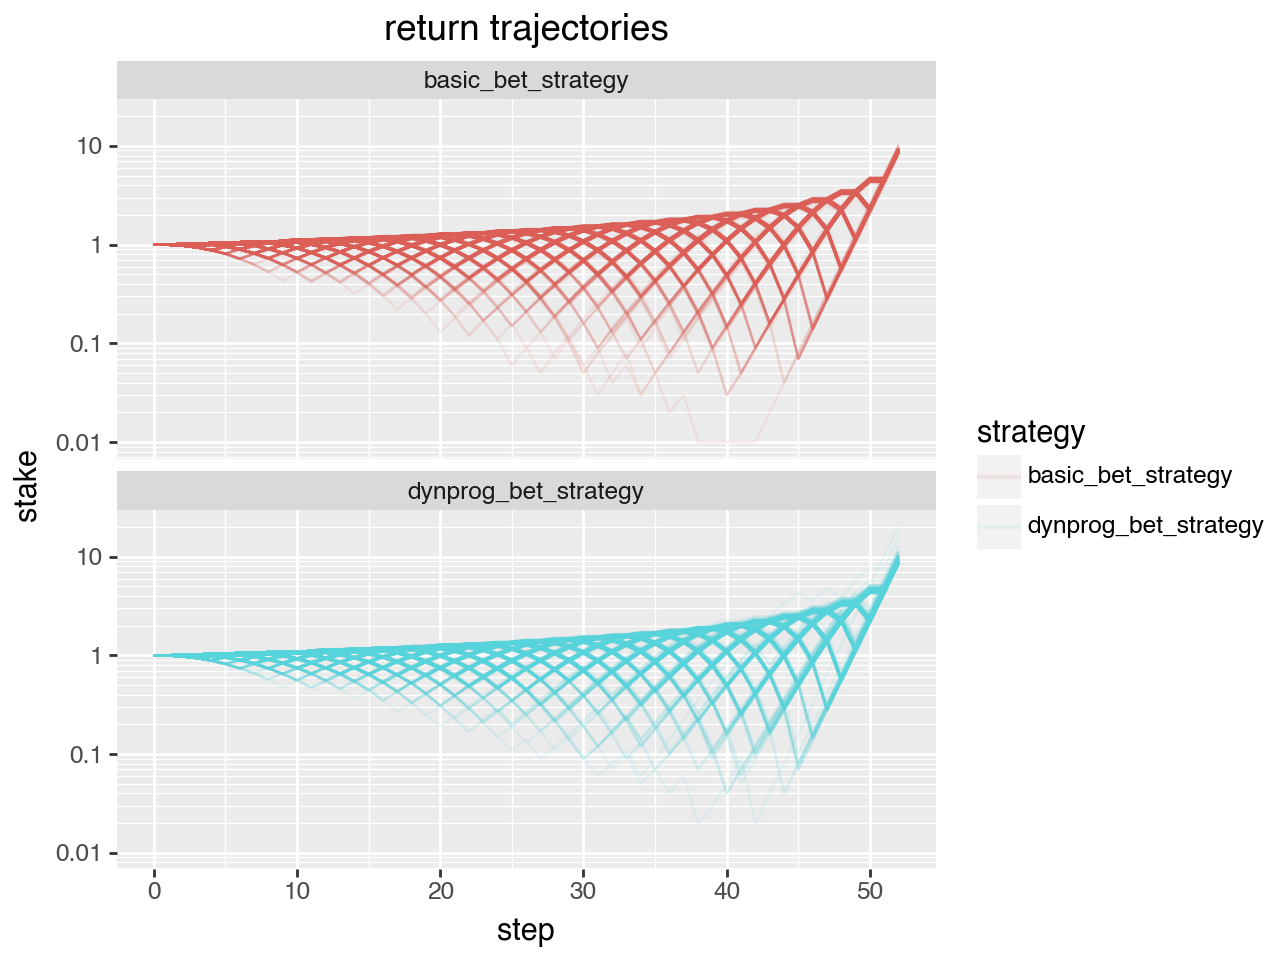

In [27]:
(
    ggplot(
        data=trajectories,
        mapping=aes(x="step", y="stake", color="strategy", group="trajectory"),
    )
    + geom_line(alpha=0.1)
    + scale_y_continuous(trans="log10")
    + facet_wrap("strategy", ncol=1)
    + ggtitle("return trajectories")
)

In [28]:
def mk_traj_frame_Kelly(i, *, decks):
    traj = []
    run_bets(decks[i], trajectory=traj)
    return pd.DataFrame(
        {
            "step": range(len(traj)),
            "stake": traj,
            "strategy": "Kelly",
            "trajectory": i,
        }
    )

In [29]:
trajectories_Kelly = pd.concat([
    mk_traj_frame_Kelly(
        i,
        decks=decks,
    )
    for i in range(1000)
], ignore_index=True)

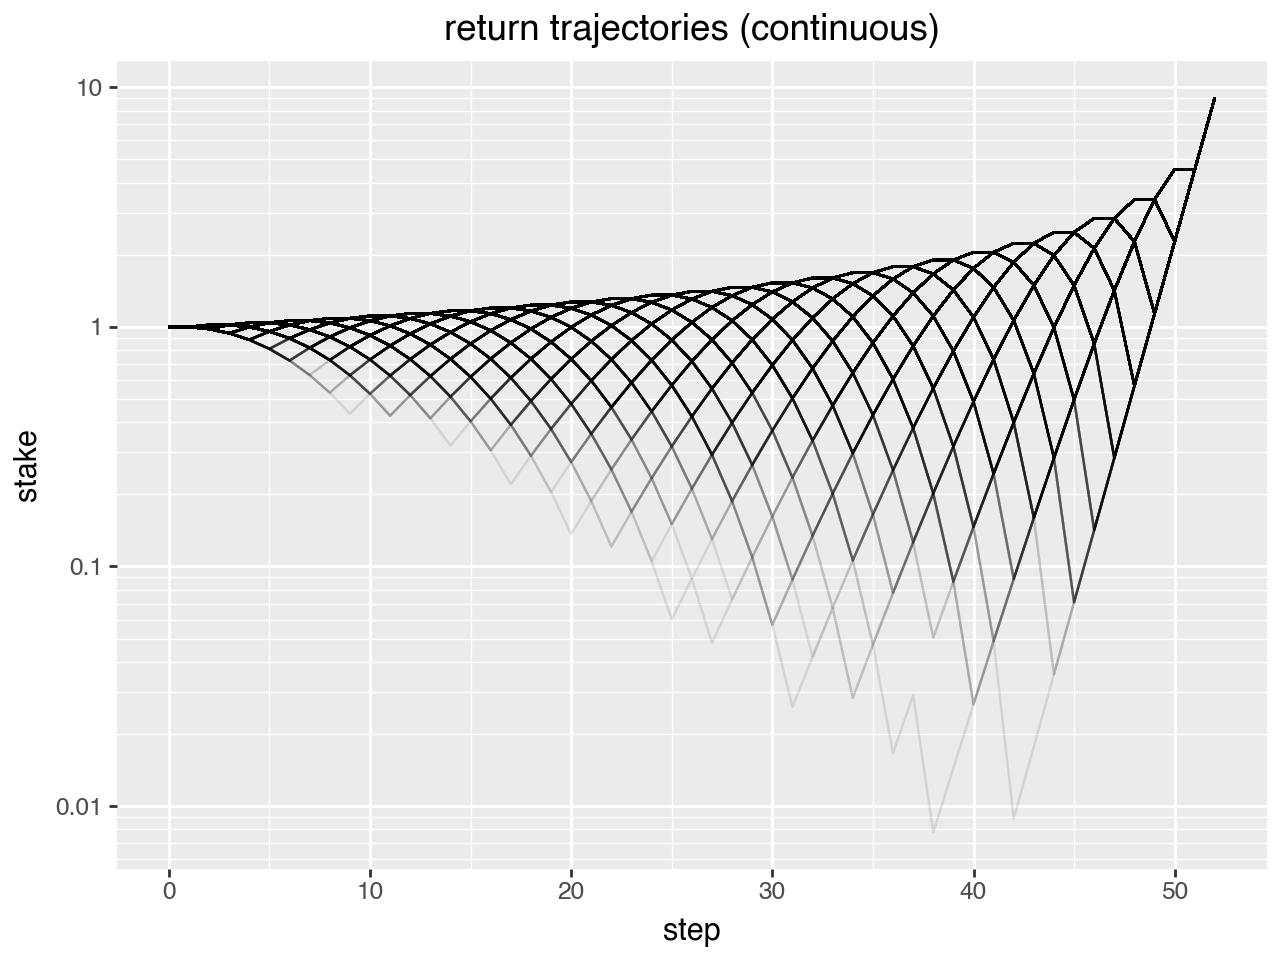

In [30]:
(
    ggplot(
        data=trajectories_Kelly,
        mapping=aes(x="step", y="stake", group="trajectory"),
    )
    + geom_line(alpha=0.1)
    + scale_y_continuous(trans="log10")
    + ggtitle("return trajectories (continuous)")
)

In [31]:

def plot_comparative_strategies(b: int, r: int):
    start_frame = pd.DataFrame({
        'stake': range(initial_stake),
        'dynprog': [ dynprog_bet_strategy(i, b, r, satiation_point, limit_to_basic_strat=limit_to_basic_strat) for i in range(initial_stake) ],
        'basic': [ basic_bet_strategy(i, b, r, satiation_point, limit_to_basic_strat=limit_to_basic_strat) for i in range(initial_stake) ],
    })
    return (
        ggplot(
            data=start_frame,
            mapping=aes(x='stake')
        )
        + geom_line(mapping=aes(y='basic'), color='blue')
        + geom_point(mapping=aes(y='dynprog'), color='green')
        + ggtitle(f"basic and dynprog bidding for ({b} black remaining, {r} red remaining)")
    )

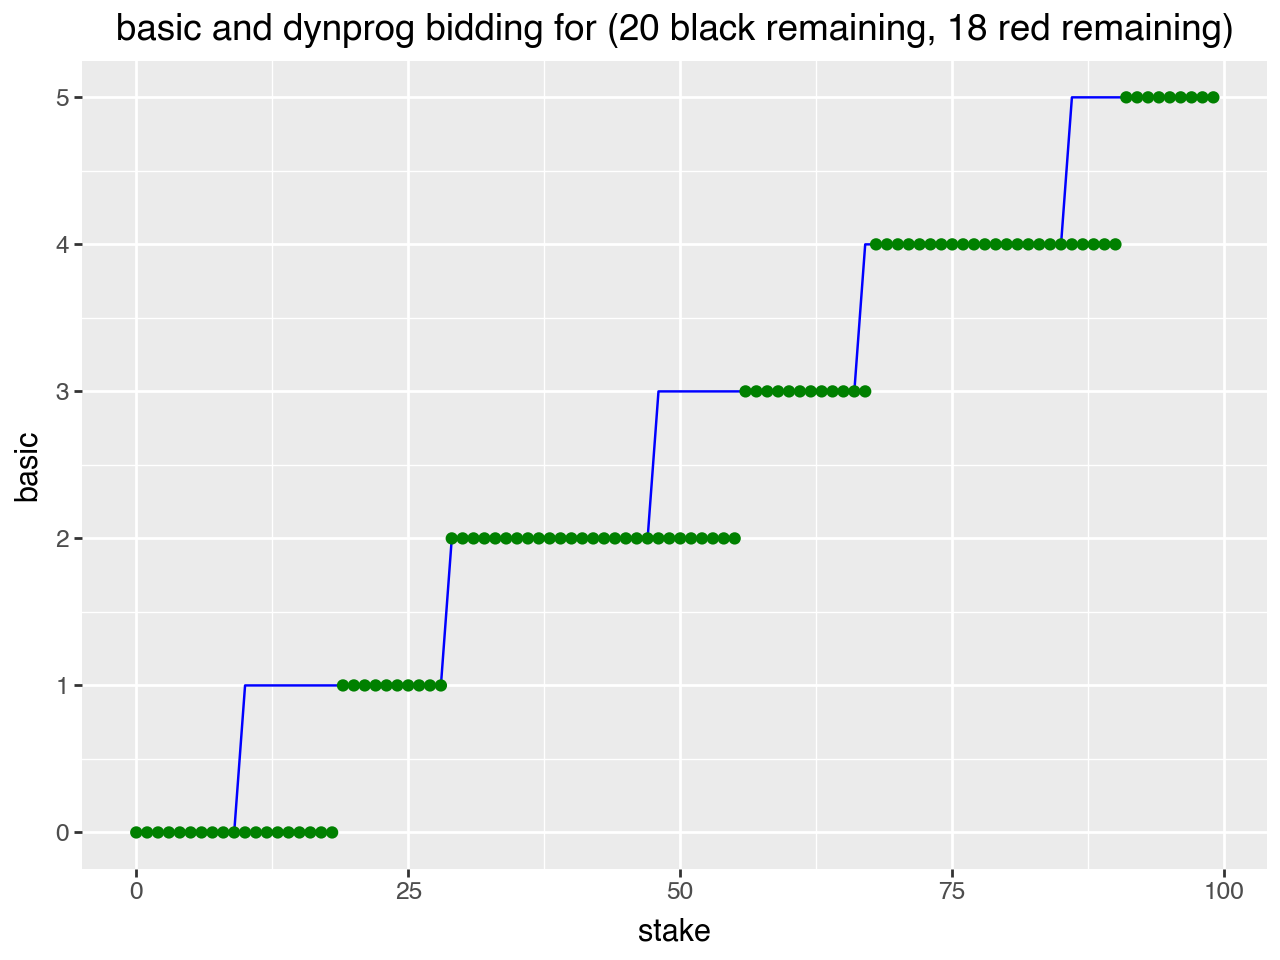

In [32]:
plot_comparative_strategies(20, 18)

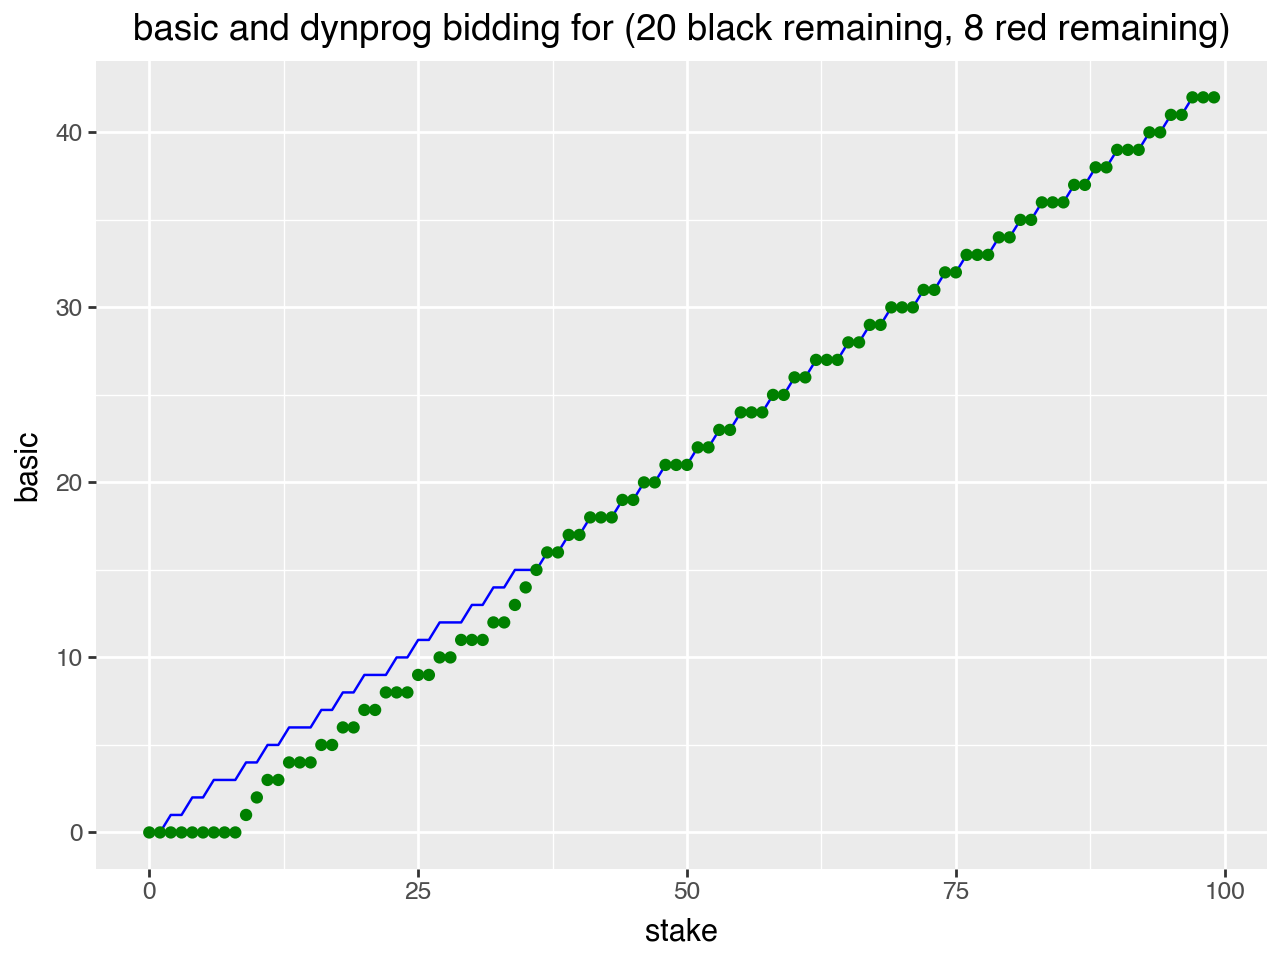

In [33]:
plot_comparative_strategies(20, 8)